In [102]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [103]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [104]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('D:\\master_an2\\NLP\\glove.6B.%sd.txt' % EMBEDDING_DIM), encoding = 'utf8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [20]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("D:\\master_an2\\NLP\\train.csv\\train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [5]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [6]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [7]:

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [8]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [9]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [10]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [11]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [15]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0838 - accuracy: 0.9834 - val_loss: 0.0738 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0674 - accuracy: 0.9930 - val_loss: 0.0716 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0624 - accuracy: 0.9931 - val_loss: 0.0707 - val_accuracy: 0.9916
Epoch 4/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0591 - accuracy: 0.9933 - val_loss: 0.0690 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0569 - accuracy: 0.9937 - val_loss: 0.0749 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0545 - accuracy: 0.9933 - val_loss: 0.0696 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0528 - accuracy: 0.9935 - val_loss: 0.07

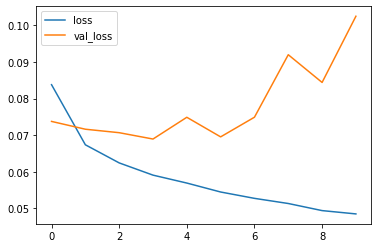

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

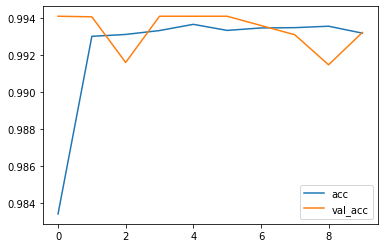

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [18]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9759526341449455


In [15]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr = 0.01),
  metrics=['accuracy']
)


In [16]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 9s 9ms/step - loss: 0.0694 - accuracy: 0.9799 - val_loss: 0.0583 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0563 - accuracy: 0.9861 - val_loss: 0.0555 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0534 - accuracy: 0.9902 - val_loss: 0.0548 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0517 - accuracy: 0.9766 - val_loss: 0.0544 - val_accuracy: 0.9940
Epoch 5/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0511 - accuracy: 0.9800 - val_loss: 0.0553 - val_accuracy: 0.9920
Epoch 6/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0500 - accuracy: 0.9732 - val_loss: 0.0540 - val_accuracy: 0.8924
Epoch 7/10
998/998 [==============================] - 8s 8ms/step - loss: 0.0494 - accuracy: 0.9807 - val_loss: 0.0538 - val_accur

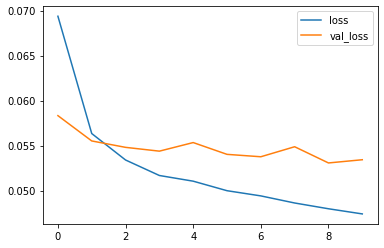

In [17]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

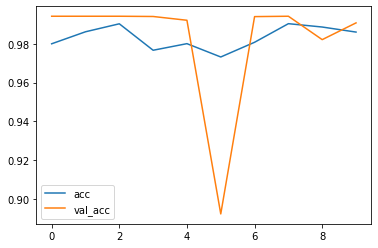

In [18]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [19]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9808712937583318


In [11]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr = 0.01),
  metrics=['accuracy']
)

Training model...
Epoch 1/10
998/998 [==============================] - 43s 41ms/step - loss: 0.0932 - accuracy: 0.9462 - val_loss: 0.0556 - val_accuracy: 0.9935
Epoch 2/10
998/998 [==============================] - 47s 47ms/step - loss: 0.0525 - accuracy: 0.9653 - val_loss: 0.0531 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 41s 42ms/step - loss: 0.0489 - accuracy: 0.9697 - val_loss: 0.0519 - val_accuracy: 0.9937
Epoch 4/10
998/998 [==============================] - 44s 44ms/step - loss: 0.0469 - accuracy: 0.9655 - val_loss: 0.0508 - val_accuracy: 0.9936
Epoch 5/10
998/998 [==============================] - 42s 42ms/step - loss: 0.0462 - accuracy: 0.9433 - val_loss: 0.0502 - val_accuracy: 0.9812
Epoch 6/10
998/998 [==============================] - 44s 44ms/step - loss: 0.0448 - accuracy: 0.9576 - val_loss: 0.0512 - val_accuracy: 0.9733
Epoch 7/10
998/998 [==============================] - 43s 43ms/step - loss: 0.0449 - accuracy: 0.9728 - val_loss: 0.05

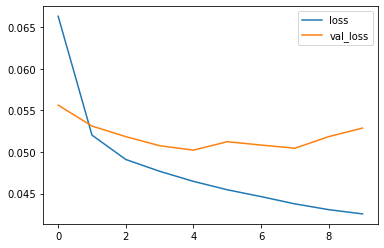

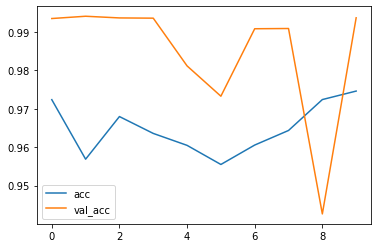

0.9850098034246998


In [12]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

In [5]:
df=pd.read_csv('D:\\Download\\labeled_data.csv',)

In [6]:
df['tweet'][20003]

'RT @shantybear: bitch do I entertain you? Cause you always seem to be in my business'

In [7]:
len(df)

24783

In [8]:
df['tweet'][14]

'" bitch get up off me "'

In [17]:
len(df)

24783

In [21]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [105]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = df_copied["new_comm"].fillna("DUMMY_VALUE").values
possible_labels = ["hate_speech","offensive_language","neither"]
targets = df[possible_labels].values

Loading in comments...


In [106]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [107]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 29
min sequence length: 0
median sequence length: 7
max word index: 19999


In [108]:

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 23400 unique tokens.


In [109]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (24783, 100)


In [110]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [46]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [31]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 3s 17ms/step - loss: -1510192.8750 - accuracy: 0.7659 - val_loss: -7272532.5000 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 2s 13ms/step - loss: -44788516.0000 - accuracy: 0.7698 - val_loss: -116918872.0000 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 2s 13ms/step - loss: -324737024.0000 - accuracy: 0.7698 - val_loss: -648682944.0000 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 2s 13ms/step - loss: -1328986624.0000 - accuracy: 0.7698 - val_loss: -2274134784.0000 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 2s 13ms/step - loss: -3944234496.0000 - accuracy: 0.7698 - val_loss: -6130970624.0000 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 2s 13ms/step - loss: -9659655168.0000 - accuracy: 0.7698 - val_loss: -13969926144.0000 - val_accuracy: 0.7924
Epoch 7/10
155

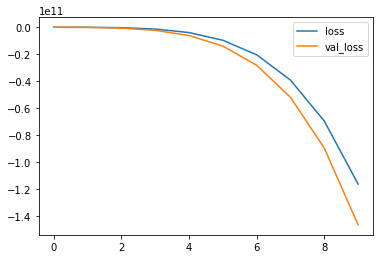

In [32]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

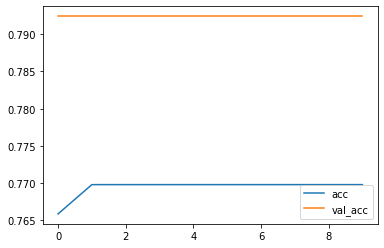

In [33]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [34]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr = 0.01),
  metrics=['accuracy']
)

In [35]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 2s 12ms/step - loss: -614.8853 - accuracy: 0.7656 - val_loss: -2147.6067 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 1s 9ms/step - loss: -5145.1333 - accuracy: 0.7698 - val_loss: -9669.6836 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 1s 9ms/step - loss: -14784.3691 - accuracy: 0.7698 - val_loss: -22476.3770 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 1s 9ms/step - loss: -29274.7930 - accuracy: 0.7698 - val_loss: -40202.9883 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 1s 9ms/step - loss: -48287.0938 - accuracy: 0.7698 - val_loss: -62540.2852 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 1s 9ms/step - loss: -71557.3438 - accuracy: 0.7698 - val_loss: -89220.0625 - val_accuracy: 0.7924
Epoch 7/10
155/155 [==============================] - 1s 9ms/step - loss: 

In [36]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr = 0.01),
  metrics=['accuracy']
)

In [37]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 3s 18ms/step - loss: -1462.3429 - accuracy: 0.7653 - val_loss: -5147.9272 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 2s 13ms/step - loss: -12361.5361 - accuracy: 0.7698 - val_loss: -23291.7305 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 2s 13ms/step - loss: -35533.1719 - accuracy: 0.7698 - val_loss: -54050.5977 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 2s 13ms/step - loss: -70285.4141 - accuracy: 0.7698 - val_loss: -96515.5156 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 2s 13ms/step - loss: -115811.0000 - accuracy: 0.7698 - val_loss: -150071.3594 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 2s 14ms/step - loss: -171489.7344 - accuracy: 0.7698 - val_loss: -214032.6094 - val_accuracy: 0.7924
Epoch 7/10
155/155 [==============================] - 2s 13ms/

In [38]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [47]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 3s 19ms/step - loss: -2334484.0000 - accuracy: 0.7686 - val_loss: -11195569.0000 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 3s 18ms/step - loss: -67258560.0000 - accuracy: 0.7698 - val_loss: -174333280.0000 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 3s 18ms/step - loss: -481243232.0000 - accuracy: 0.7698 - val_loss: -953166976.0000 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 3s 18ms/step - loss: -1944119808.0000 - accuracy: 0.7698 - val_loss: -3297805056.0000 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 3s 19ms/step - loss: -5745910272.0000 - accuracy: 0.7698 - val_loss: -8861417472.0000 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 3s 19ms/step - loss: -13854026752.0000 - accuracy: 0.7698 - val_loss: -20013641728.0000 - val_accuracy: 0.7924
Epoch 7/10
1

In [51]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,padding = 'same', activation = 'relu')(x)
x = Dropout(0.7)(x)
x = MaxPooling1D()(x)
x = LSTM(10)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr = 0.01),
  metrics=['accuracy']
)

In [52]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 3s 22ms/step - loss: -528.1242 - accuracy: 0.7649 - val_loss: -1875.2336 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 3s 19ms/step - loss: -4533.6040 - accuracy: 0.7698 - val_loss: -8535.2031 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 3s 19ms/step - loss: -13023.6133 - accuracy: 0.7698 - val_loss: -19813.9980 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 3s 19ms/step - loss: -25728.1133 - accuracy: 0.7698 - val_loss: -35342.4805 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 3s 18ms/step - loss: -42399.8086 - accuracy: 0.7698 - val_loss: -54990.3359 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 3s 18ms/step - loss: -62823.2734 - accuracy: 0.7698 - val_loss: -78534.0547 - val_accuracy: 0.7924
Epoch 7/10
155/155 [==============================] - 3s 19ms/step - 

In [56]:
import re
a= ' '

In [55]:
a.replace

<function str.replace(old, new, count=-1, /)>

In [11]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from nltk import sent_tokenize

In [24]:
comment_example = df['tweet'][20003]

In [12]:
sentences = sent_tokenize(comment_example)

In [17]:
tokens = word_tokenize(comment_example)

In [18]:
tokens

['RT',
 '@',
 'shantybear',
 ':',
 'bitch',
 'do',
 'I',
 'entertain',
 'you',
 '?',
 'Cause',
 'you',
 'always',
 'seem',
 'to',
 'be',
 'in',
 'my',
 'business']

In [19]:
words = [word for word in tokens if word.isalpha()]

In [20]:
words

['RT',
 'shantybear',
 'bitch',
 'do',
 'I',
 'entertain',
 'you',
 'Cause',
 'you',
 'always',
 'seem',
 'to',
 'be',
 'in',
 'my',
 'business']

In [21]:
from nltk.corpus import stopwords

In [22]:
stop_words = stopwords.words('english')

In [23]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [26]:
#split into words
tokens = word_tokenize(comment_example)
#convert to lower case
tokens = [w.lower() for w in tokens]
#remove punctuation from each word
import string
table = str.maketrans('','', string.punctuation)
stripped = [w.translate(table) for w in tokens]
#remove remaining tokens that are not alphabetic
word = [word for word in stripped if word.isalpha()]
#filter out stop words
words = [w for w in words if not w in stop_words]
words


['RT',
 'shantybear',
 'bitch',
 'I',
 'entertain',
 'Cause',
 'always',
 'seem',
 'business']

In [27]:
tokens = [w.lower() for w in words]

In [40]:
tokens[2:]

['bitch', 'i', 'entertain', 'cause', 'always', 'seem', 'business']

In [38]:
df['tweet'][1]

'!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'

In [96]:
#for all the dataset
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 = str1+ ele +' '   
    
    # return string   
    return str1  
        
        





df_copied = df.copy()
wrd_vec = []
for i in range(len(df_copied)):
    rt = 0
    ar = 0
    comment = df['tweet'][i]

    if 'RT' in comment:
        rt=1
    if '@' in comment:
        ar = 1
    
    tokens = word_tokenize(comment)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    word = [word for word in stripped if word.isalpha()]
    #filter out stop words
    words = [w for w in word if not w in stop_words]
    words = [w.lower() for w in words]
    if rt == 1:
        words = words[2:]
    elif ar == 1:
        words = words[1:]
    
    words = listToString(words)
    wrd_vec.append(words)
    

    

In [97]:
df_copied['new_comm'] = wrd_vec

In [98]:
df_copied['new_comm'][0][:]

'woman nt complain cleaning house amp man always take trash '

In [99]:
df_copied

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,new_comm
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman nt complain cleaning house amp man alway...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,dats cold tyga dwn bad cuffin dat hoe place
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg rt ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,vivabased look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,lie lifeasking coreyemanuel right tl trash min...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


In [111]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [112]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
155/155 [==============================] - 3s 16ms/step - loss: -383754.7188 - accuracy: 0.7651 - val_loss: -1847826.7500 - val_accuracy: 0.7924
Epoch 2/10
155/155 [==============================] - 2s 12ms/step - loss: -10827851.0000 - accuracy: 0.7698 - val_loss: -28591412.0000 - val_accuracy: 0.7924
Epoch 3/10
155/155 [==============================] - 2s 12ms/step - loss: -78024040.0000 - accuracy: 0.7698 - val_loss: -155816080.0000 - val_accuracy: 0.7924
Epoch 4/10
155/155 [==============================] - 2s 13ms/step - loss: -314103584.0000 - accuracy: 0.7698 - val_loss: -541202880.0000 - val_accuracy: 0.7924
Epoch 5/10
155/155 [==============================] - 2s 13ms/step - loss: -929371520.0000 - accuracy: 0.7698 - val_loss: -1450195968.0000 - val_accuracy: 0.7924
Epoch 6/10
155/155 [==============================] - 2s 13ms/step - loss: -2256549632.0000 - accuracy: 0.7698 - val_loss: -3289814272.0000 - val_accuracy: 0.7924
Epoch 7/10
155/155 [=

# Does NLP work better when we have less data?

In [117]:
df1,df2,df3,df4,df5,df6 = np.array_split(df_copied,6)

# Blank DL

In [118]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = df1["new_comm"].fillna("DUMMY_VALUE").values
possible_labels = ["hate_speech","offensive_language","neither"]
targets = df1[possible_labels].values
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            
            
            
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Loading in comments...
Found 7693 unique tokens.
Shape of data tensor: (4131, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/10
26/26 [==============================] - 1s 34ms/step - loss: -639.9284 - accuracy: 0.7491 - val_loss: -2209.4912 - val_accuracy: 0.7267
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: -14683.6045 - accuracy: 0.7742 - val_loss: -24220.4570 - val_accuracy: 0.7267
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: -77417.9453 - accuracy: 0.7742 - val_loss: -97760.8906 - val_accuracy: 0.7267
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: -253417.2656 - accuracy: 0.7742 - val_loss: -281040.8438 - val_accuracy: 0.7267
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: -642375.1875 - accuracy: 0.7742 - val_loss: -648141.4375 - val_accuracy: 0.7267
Epoch 6/10
26/26 [==============================] - 0s 14ms/step - loss: -1365832.2500 - ac

In [119]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = df1["tweet"].fillna("DUMMY_VALUE").values
possible_labels = ["hate_speech","offensive_language","neither"]
targets = df1[possible_labels].values
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            
            
            
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Loading in comments...
Found 11733 unique tokens.
Shape of data tensor: (4131, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/10
26/26 [==============================] - 0s 19ms/step - loss: -1962.9346 - accuracy: 0.7476 - val_loss: -6660.7480 - val_accuracy: 0.7267
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: -46866.3867 - accuracy: 0.7742 - val_loss: -74469.6641 - val_accuracy: 0.7267
Epoch 3/10
26/26 [==============================] - 0s 13ms/step - loss: -260441.1250 - accuracy: 0.7742 - val_loss: -315022.1875 - val_accuracy: 0.7267
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: -861585.2500 - accuracy: 0.7742 - val_loss: -902609.9375 - val_accuracy: 0.7267
Epoch 5/10
26/26 [==============================] - 0s 14ms/step - loss: -2157570.0000 - accuracy: 0.7742 - val_loss: -2067867.8750 - val_accuracy: 0.7267
Epoch 6/10
26/26 [==============================] - 0s 15ms/step - loss: -4627347.000

# One more try

In [125]:
df11,df2,df3,df4,df5,df6,df7,df8,df9,df10 = np.array_split(df1,10)

In [126]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = df11["new_comm"].fillna("DUMMY_VALUE").values
possible_labels = ["hate_speech","offensive_language","neither"]
targets = df11[possible_labels].values
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            
            
            
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Loading in comments...
Found 1483 unique tokens.
Shape of data tensor: (414, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/10
3/3 [==============================] - 1s 326ms/step - loss: -0.0679 - accuracy: 0.5952 - val_loss: -3.6871 - val_accuracy: 0.7952
Epoch 2/10
3/3 [==============================] - 0s 21ms/step - loss: -9.4048 - accuracy: 0.8459 - val_loss: -32.5795 - val_accuracy: 0.7952
Epoch 3/10
3/3 [==============================] - 0s 20ms/step - loss: -59.6174 - accuracy: 0.8459 - val_loss: -136.2076 - val_accuracy: 0.7952
Epoch 4/10
3/3 [==============================] - 0s 20ms/step - loss: -204.5163 - accuracy: 0.8459 - val_loss: -365.2686 - val_accuracy: 0.7952
Epoch 5/10
3/3 [==============================] - 0s 18ms/step - loss: -499.4500 - accuracy: 0.8459 - val_loss: -784.3727 - val_accuracy: 0.7952
Epoch 6/10
3/3 [==============================] - 0s 19ms/step - loss: -1015.0589 - accuracy: 0.8459 - val_loss: -1447.8655 - val_

In [127]:
# prepare text samples and their labels
print('Loading in comments...')

sentences = df11["tweet"].fillna("DUMMY_VALUE").values
possible_labels = ["hate_speech","offensive_language","neither"]
targets = df11[possible_labels].values
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            
            
            
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Loading in comments...
Found 2234 unique tokens.
Shape of data tensor: (414, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/10
3/3 [==============================] - 0s 65ms/step - loss: -0.3568 - accuracy: 0.6012 - val_loss: -6.5104 - val_accuracy: 0.7952
Epoch 2/10
3/3 [==============================] - 0s 21ms/step - loss: -18.3303 - accuracy: 0.8459 - val_loss: -66.1213 - val_accuracy: 0.7952
Epoch 3/10
3/3 [==============================] - 0s 24ms/step - loss: -126.4505 - accuracy: 0.8459 - val_loss: -291.1189 - val_accuracy: 0.7952
Epoch 4/10
3/3 [==============================] - 0s 22ms/step - loss: -460.4619 - accuracy: 0.8459 - val_loss: -841.8262 - val_accuracy: 0.7952
Epoch 5/10
3/3 [==============================] - 0s 24ms/step - loss: -1197.0652 - accuracy: 0.8459 - val_loss: -1852.4966 - val_accuracy: 0.7952
Epoch 6/10
3/3 [==============================] - 0s 22ms/step - loss: -2489.4368 - accuracy: 0.8459 - val_loss: -3494.7515 - v

In [128]:
len(df11)

414

In [130]:
train = pd.read_csv("D:\\master_an2\\NLP\\train.csv\\train.csv")
len(train)

159571